In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
path = '~/Desktop/practice/denoising-dirty-documents/data'
trainInPath = path + '/train'
trainOutPath = path + '/train_cleaned'
testPath = path + '/test'

In [3]:
def loadImg(path):
    data = []
    for title in sorted(os.listdir(path)):
        img = cv2.imread(path + '/' + title)
        #zero centre
        img = np.asarray(img, dtype = np.float32)
        img = img / 255.0
        data.append(img)
    return data

def saveImg(path, data):
    for i,img in enumerate(data):
        img = np.asarray(img * 255.0, dtype = np.uint8)
        Image.fromarray(img).save(path+'/'+str(i)+'.png')

In [4]:
train = loadImg(trainInPath)
train_cleaned = loadImg(trainOutPath)
test = loadImg(testPath)

In [5]:
#Filter

In [6]:
out_blur = []
out_Guassian = []
out_Median = []
out_Bilateral = []

MAX_KERNEL_LENGTH = 40
for i in range(1, MAX_KERNEL_LENGTH, 2):
    for j in train:
        #Normalized Box Filter
        out_blur.append(cv2.blur(j,(i,i)))
        #Gaussian Filter
        out_Guassian.append(cv2.GaussianBlur(j, (i,i), 0))
        #median Filter
        out_Median.append(np.asarray((cv2.medianBlur(np.asarray(j * 255.0, dtype = np.uint8), i))/255.0,dtype = np.float32))
        #Bilateral Filter
        out_Bilateral.append(cv2.bilateralFilter(j, i, i*2, i/2))

In [7]:
#saveImg(path+'/'+'Filter',output)

In [8]:
print('output len: ' + str(len(out_blur)))
print('train len: ' + str(len(train)))
print(len(out_blur)/len(train))

output len: 2880
train len: 144
20.0


In [9]:
def calDiff(train_cleaned,train,output):
    img = train - output
    img = np.asarray(img * 255.0, dtype = np.uint8)
    img = np.where(img/255.0,train,1.0)
    return abs(train_cleaned - img)


def NewcalDiff(train_cleaned,train,output):
    deeper = 0.1
    img = train < output - deeper
    return abs(np.where(img,train,1.0)-train_cleaned)

def calPoint(output,train,train_cleaned):
    differents = []
    reTime = int(len(output)/len(train))
    for i in range(len(train)):
        for j in range(reTime):
            tmp = NewcalDiff(train_cleaned[i],train[i],output[i+j*len(train)])
            #tmp = abs(abs(abs(train[i]) - abs(output[i+j*len(train)])) - abs(train_cleaned[i]))
            differents.append(tmp)
    return differents

In [12]:
blur_diff = []
gaussian_diff = []
median_diff = []
bilateral_diff = []


d_blur = calPoint(out_blur,train,train_cleaned)
d_Gaussian = calPoint(out_Guassian,train,train_cleaned)
d_Median = calPoint(out_Median,train,train_cleaned)
d_Bilateral = calPoint(out_Bilateral,train,train_cleaned)

for i in d_blur:
    blur_diff.append(sum(sum(sum(i))))
for i in d_Gaussian:
    gaussian_diff.append(sum(sum(sum(i))))
for i in d_Median:
    median_diff.append(sum(sum(sum(i))))
for i in d_Bilateral:
    bilateral_diff.append(sum(sum(sum(i))))


In [13]:
# pick up the smallest
index = 3
def calItr(blur_diff,index):
    itr, small = 0, blur_diff[index]
    for i,j in  enumerate(blur_diff[index::144]):
        if j <= small:
            small = j
            itr = i
    return itr
itr_blur = calItr(blur_diff,index)
itr_Gaussian = calItr(gaussian_diff,index)
itr_median = calItr(median_diff,index)
itr_bilateral = calItr(bilateral_diff,index)
#print(itr_bilateral)
#print(d_blur[1])
#print(sum(sum(sum(d_blur[4]))))

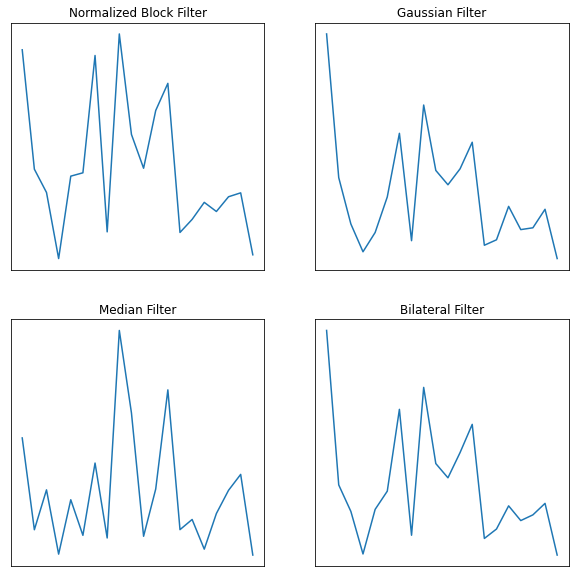

In [14]:
# the different between
plt.figure(figsize=(10,10))
#blur
plt.subplot(2,2,1)
plt.plot(blur_diff[index::144])
plt.title('Normalized Block Filter')
#gaussian
plt.subplot(2,2,2)
plt.plot(gaussian_diff[index::144])
plt.title('Gaussian Filter')
#median
plt.subplot(2,2,3)
plt.plot(median_diff[index::144])
plt.title('Median Filter')
#bilateral
plt.subplot(2,2,4)
plt.plot(bilateral_diff[index::144])
plt.title('Bilateral Filter')

plt.show()

In [17]:
len(out_blur)

def displayConv(img):
    return np.asarray(img*255.0, dtype = np.uint8)

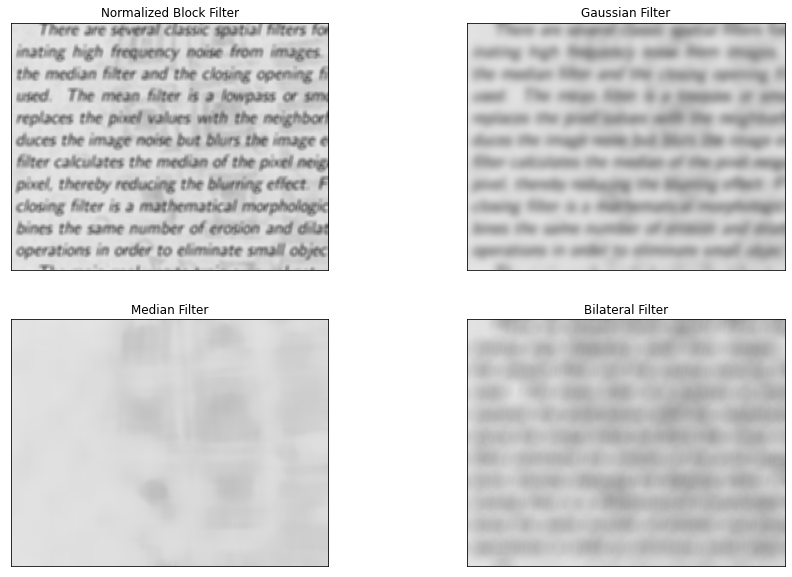

In [18]:
#The background
plt.figure(figsize=(15,10))
#blur
plt.subplot(2,2,1)
plt.xticks([])
plt.yticks([])
plt.imshow(displayConv(out_blur[index+itr_blur*len(train)]))
plt.title('Normalized Block Filter')
#gaussian
plt.subplot(2,2,2)
plt.xticks([])
plt.yticks([])
plt.imshow(displayConv(out_Guassian[index+itr_Gaussian*len(train)]))
plt.title('Gaussian Filter')
#median
plt.subplot(2,2,3)
plt.xticks([])
plt.yticks([])
plt.imshow(displayConv(out_Median[index+itr_median*len(train)]))
plt.title('Median Filter')
#bilateral
plt.subplot(2,2,4)
plt.xticks([])
plt.yticks([])
plt.imshow(displayConv(out_Bilateral[index+itr_bilateral*len(train)]))

plt.title('Bilateral Filter')

plt.show()

#plt.imshow(output[3+itr*len(train)])

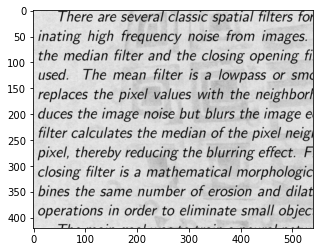

In [19]:
# The original picture
plt.imshow(train[3])

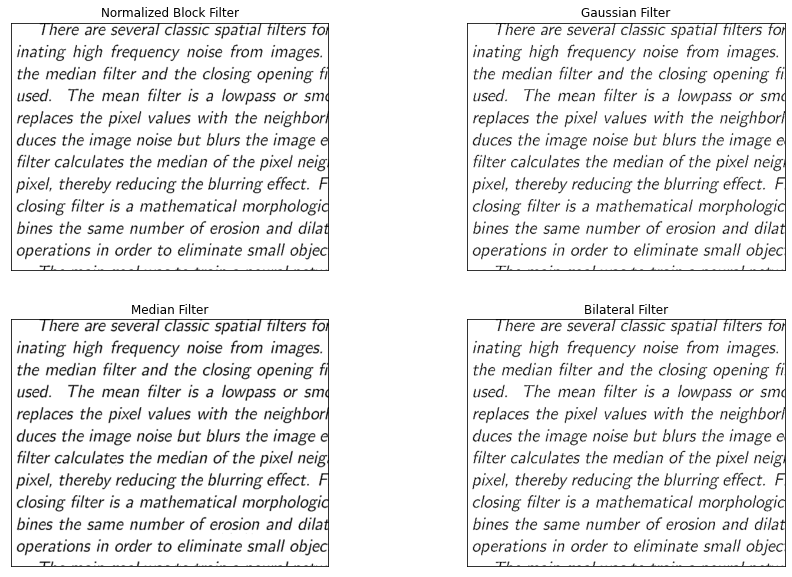

In [21]:
# The 'cleaned' picture
plt.figure(figsize=(15,10))

#For the solution described by Rangel Dokov
#Url: https://www.kaggle.com/rdokov/background-removal
#Compute the foreground(text) which is considered darker than the background
def NewcleanPic(background,train):
    deeper = 0.1
    img = train < background - deeper
    return np.where(img,train,1.0)
    #return img

#blur
plt.subplot(2,2,1)
plt.xticks([])
plt.yticks([])
plt.imshow(displayConv(NewcleanPic(out_blur[index+itr_blur*len(train)],train[index])))
plt.title('Normalized Block Filter')
#gaussian
plt.subplot(2,2,2)
plt.xticks([])
plt.yticks([])
plt.imshow(displayConv(NewcleanPic(out_Guassian[index+itr_blur*len(train)],train[index])))
plt.title('Gaussian Filter')
#median
plt.subplot(2,2,3)
plt.xticks([])
plt.yticks([])
plt.imshow(displayConv(NewcleanPic(out_Median[index+itr_blur*len(train)],train[index])))
plt.title('Median Filter')
#bilateral
plt.subplot(2,2,4)
plt.xticks([])
plt.yticks([])
plt.imshow(displayConv(NewcleanPic(out_Bilateral[index+itr_blur*len(train)],train[index])))
plt.title('Bilateral Filter')

plt.show()

#test = np.where(img,train[3],1.0)
#plt.imshow(test)

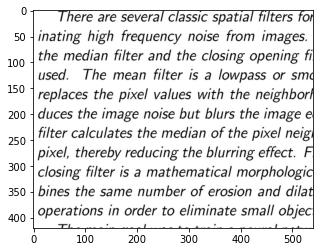

In [22]:
# clean picture
plt.imshow(train_cleaned[3])

In [23]:
print(itr_blur)
print(itr_Gaussian)
print(itr_median)
print(itr_bilateral)

3
19
19
19


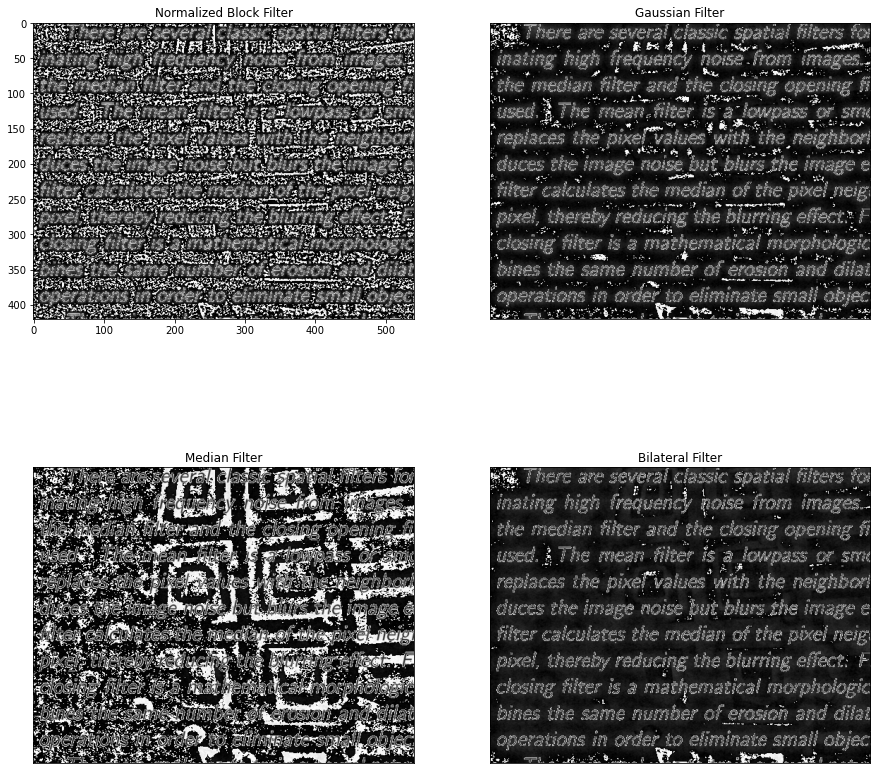

In [30]:
#extract the foreground which is generated by simply minus the background of original picture
#itr = 3
def foreground(output,length,index,itr):
    img = train[index]-output[index+itr*len(train)]
    #img = np.asarray(img * 255.0, dtype = np.uint8)
    return img

img_blur = foreground(out_blur,len(train),index,itr_blur)
img_Gaussian = foreground(out_Guassian,len(train),index,itr_Gaussian)
img_Median = foreground(out_Median,len(train),index,itr_median)
img_Bilateral = foreground(out_Bilateral,len(train),index,itr_bilateral)
#plt.imshow(img)
#img
#display 
plt.figure(figsize=(15,15))
#blur
plt.subplot(2,2,1)
plt.xticks([])
plt.yticks([])
plt.imshow(displayConv(img_blur))
plt.title('Normalized Block Filter')
#gaussian
plt.subplot(2,2,2)
plt.xticks([])
plt.yticks([])
plt.imshow(displayConv(img_Gaussian))
plt.title('Gaussian Filter')
#median
plt.subplot(2,2,3)
plt.xticks([])
plt.yticks([])
plt.imshow(displayConv(img_Median))
plt.title('Median Filter')
#bilateral
plt.subplot(2,2,4)
plt.xticks([])
plt.yticks([])
plt.imshow(displayConv(img_Bilateral))
plt.title('Bilateral Filter')

plt.show()

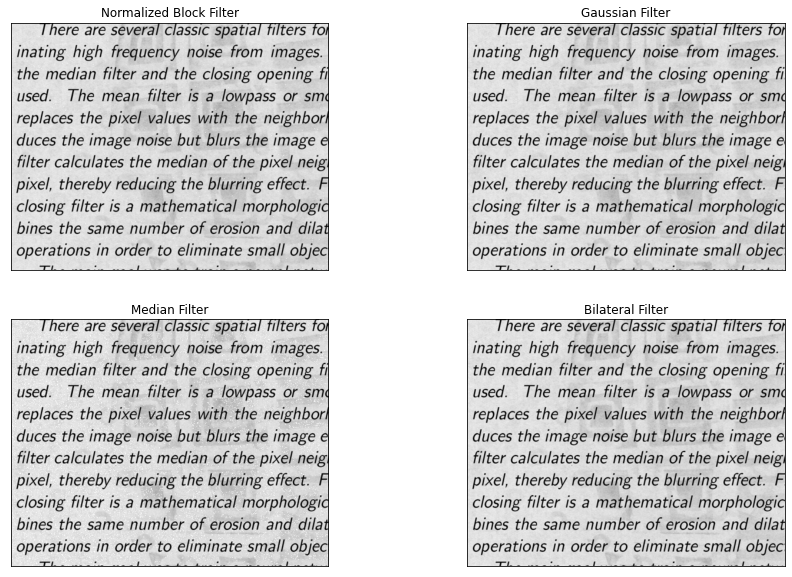

In [25]:
# The 'cleaned' picture
plt.figure(figsize=(15,10))
def cleanPic(img,train):
    return np.where(img,train,1.0)

#blur
plt.subplot(2,2,1)
plt.xticks([])
plt.yticks([])
plt.imshow(displayConv(cleanPic(img_blur,train[index])))
plt.title('Normalized Block Filter')
#gaussian
plt.subplot(2,2,2)
plt.xticks([])
plt.yticks([])
plt.imshow(displayConv(cleanPic(img_Gaussian,train[index])))
plt.title('Gaussian Filter')
#median
plt.subplot(2,2,3)
plt.xticks([])
plt.yticks([])
plt.imshow(displayConv(cleanPic(img_Median,train[index])))
plt.title('Median Filter')
#bilateral
plt.subplot(2,2,4)
plt.xticks([])
plt.yticks([])
plt.imshow(displayConv(cleanPic(img_Bilateral,train[index])))
plt.title('Bilateral Filter')

plt.show()

#test = np.where(img,train[3],1.0)
#plt.imshow(test)

In [27]:
def calItr(blur_diff,index):
    itr, small = 0, blur_diff[index]
    for i,j in  enumerate(blur_diff[index::144]):
        if j <= small:
            small = j
            itr = i
    return itr

blur = []
Gaussian = []
median = []
bilateral = []
for i in range(len(train)):
    blur.append(calItr(blur_diff,i))
    Gaussian.append(calItr(gaussian_diff,i))
    median.append(calItr(median_diff,i))
    bilateral.append(calItr(bilateral_diff,i))

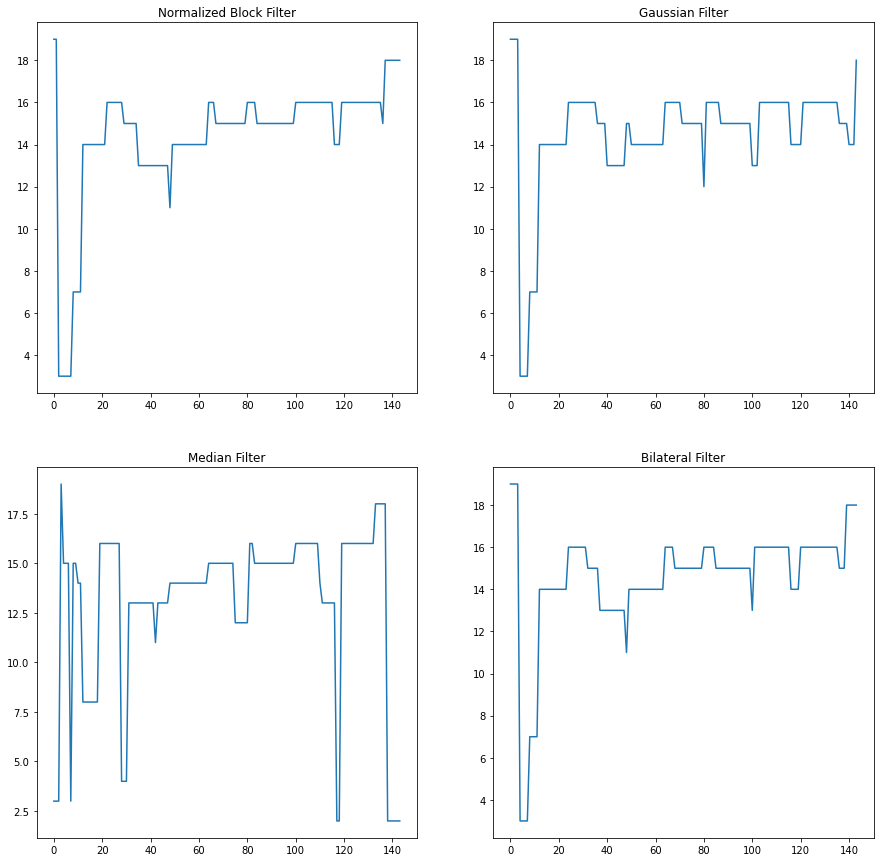

In [32]:
# the different between
plt.figure(figsize=(15,15))
#blur
plt.subplot(2,2,1)
plt.plot(blur)
plt.title('Normalized Block Filter')
#gaussian
plt.subplot(2,2,2)
plt.plot(Gaussian)
plt.title('Gaussian Filter')
#median
plt.subplot(2,2,3)
plt.plot(median)
plt.title('Median Filter')
#bilateral
plt.subplot(2,2,4)
plt.plot(bilateral)
plt.title('Bilateral Filter')

plt.show()